In [ ]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import inspect
from collections import namedtuple
import sys
from pyprojroot import here
import feather
root = here()
sys.path.append(str(root))
wdir = root / "data" / "interim" / "tides"
from tidal_flat_0d import models, features, visualization

In [ ]:
grain_dia = 0.000035  # grain diameter (m)
grain_den = 2650
settle_rate = models.stokes_settling(grain_dia=grain_dia, grain_den=grain_den)

tide_name = "tides-debug.feather"
tide_series = features.load_tide(wdir, tide_name)

index = tide_series.pressure.index
water_height = tide_series.pressure.values

params = features.make_param_tuple(water_height=water_height, index=index, bound_conc=0.8, settle_rate=settle_rate, bulk_den=1100, start_elev=1, tidal_amplifier=1, conc_method='JG', organic_rate=0, compaction_rate=0, subsidence_rate=0)

In [ ]:
data = models.simulate_elevation(params)

In [ ]:
visualization.plot_results(data)

In [642]:
from scipy.interpolate import interp1d
tide_func = interp1d(np.arange(1,len(index)+1,1), water_height, bounds_error=False, fill_value="extrapolate")
dhdt = np.gradient(water_height)
dhdt_func = interp1d(np.arange(0,len(index),1), dhdt, bounds_error=False, fill_value="extrapolate")

def calc_conc(t, y):
    global bound_conc, elev, settle_rate
    
    water_height = tide_func(t)
    
    dhdt = dhdt_func(t)
    
    depth = water_height - elev

    # Checks
    tide_above_platform = depth > 0
    tide_increasing = dhdt > 0

    if tide_above_platform:
        if tide_increasing:
            dy = - (settle_rate * y) / depth - 1 / depth * (y - bound_conc) * dhdt
            if y + dy < 0:
                dy = -y
            return dy
        if not tide_increasing:
            dy = - (settle_rate * y) / depth
            if y + dy < 0:
                dy = -y
            return dy
        else:
            raise Exception('Tide not increasing or decreasing.')
    if not tide_above_platform:
        dy = 0
        return dy
    else:
        print(tide_above_platform, prev_tide_above_platform, tide_increasing)
        raise Exception('Error in tide_above_platform or depth_stable')

In [639]:
from scipy.integrate import RK45
bound_conc=0.8
tides=water_height
elev=0
settle_rate=settle_rate
t_span = np.arange(1,len(index), 1)


conc = np.zeros(len(t_span))
time = np.zeros(len(t_span))
mod=RK45(fun=calc_conc, t0=t_span[0], y0=[0.8], t_bound=t_span[-1])

time = np.empty(0)
conc = np.empty(0)
while mod.status == 'running':
    mod.step()
    time = np.append(time, mod.t)
    conc = np.append(conc, mod.y)

In [630]:
mod.status

'finished'

In [ ]:
y = 0
y_arr = np.empty(0)
dy_arr = np.empty(0)
for t in t_span:
    dy = calc_conc(t,y)
    dy_arr = np.append(dy_arr, dy)
    y = y + dy
    y_arr = np.append(y_arr, y)

In [658]:
from scipy.integrate import solve_ivp
elev = 0.1
sol = solve_ivp(fun=calc_conc, t_span=[t_span[0], t_span[-1]], y0=[0], first_step=1, t_eval=t_span)

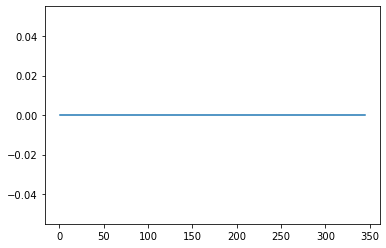

In [659]:
plt.plot(sol.t,sol.y[0])

In [650]:
sol.y

array([[0.00000000e+00, 9.07533181e-02, 1.28829988e-01, 1.51762110e-01,
        1.62642815e-01, 1.67298537e-01, 1.69010929e-01, 1.69534133e-01,
        1.69650163e-01, 1.69644820e-01, 1.69584596e-01, 1.69434415e-01,
        1.69034994e-01, 1.68143025e-01, 1.66511187e-01, 1.63525480e-01,
        1.58144641e-01, 1.49261158e-01, 1.35539112e-01, 1.15466043e-01,
        8.80627158e-02, 5.71257523e-02, 3.10473441e-02, 1.08341140e-02,
        7.38318602e-03, 5.02081214e-03, 1.94145049e-03, 7.54950852e-04,
        2.72173552e-04, 1.95895111e-04, 1.39249086e-04, 9.48161136e-05,
        6.32724466e-05, 4.07435501e-05, 2.54370246e-05, 1.51095710e-05,
        8.53665668e-06, 4.51175077e-06, 2.18796952e-06, 9.74258955e-07,
        3.70446529e-07, 1.39908302e-07, 3.72445892e-07, 2.12441473e-07,
        1.11926110e-07, 4.20579147e-08, 1.40812244e-07, 7.02902558e-08,
        3.08084632e-08, 1.17255934e-08, 8.68610051e-09, 3.32708042e-09,
        1.69504231e-09, 5.85717399e-10, 1.65321882e-09, 7.078601